COPY FROM t1 FOLDER: change input to have time-dependency and add LSTM model

Search for "FIXME" for tunable parameters

## Import libraries

In [1]:
print("load libraries")
import numpy as np
from sklearn.decomposition import PCA
import utils
import keras

# https://stackoverflow.com/a/34306306/4126114
np.random.seed(0)

load libraries


Using TensorFlow backend.


## Generate data

(10000, 2)
X [[ 0.72982333  0.27017667]
 [ 0.54897761  0.45102239]
 [ 0.62569454  0.37430546]
 [ 0.79305005  0.20694995]
 [ 0.74354766  0.25645234]
 [ 0.36633656  0.63366344]
 [ 0.62189575  0.37810425]
 [ 0.47584954  0.52415046]
 [ 0.48223245  0.51776755]
 [ 0.55036207  0.44963793]]


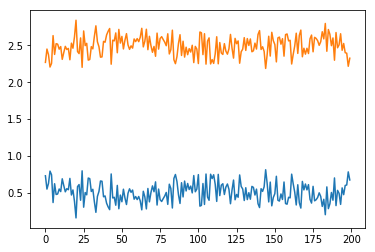

In [2]:
N=int(1e4) # FIXME 1e5

# Try dataset from https://stats.stackexchange.com/questions/190148/autoencoder-pca-tensorflow?rq=1
from sklearn.preprocessing import scale
def data1(n_samples:int=2000):
    n_features=5
    # n_samples, n_features = 2000, 5
    # X = np.random.uniform(0, 1, (n_samples, n_features))
    X = np.zeros((n_samples,n_features))
    
    sigma = 0.1
    xt=np.arange(0,n_samples/10,1/10)
    X[:,0] = .5 + .5*np.sin(1*xt) + np.random.normal(0, sigma, N) +1 # first sine wave
    X[:,1] = .5 + .5*np.sin(2*xt) + np.random.normal(0, sigma, N) +1 # second sine wave
    X[:,2] = 1*np.cos(1*xt) + np.random.normal(0, sigma, N) +1 # lagged version of first sine wave
    X[:,3] = X[:,1]*X[:, 2] # some non-linear relations between lagged and other
    X[:,4] = X[:,1]**2 * X[:, 0]**3 # some non-linear relations between 2 sines
    # auto-encoders need [0-1] range data
    # If PCA input is (mean=0,std=1) and AE is [0-1], MSE is incomparable
    # X = scale(X)
    X = utils.myNorm3(X)
    return X

def data2(n_samples:int=2000):
    n_features=2
    # n_samples, n_features = 2000, 5
    # X = np.random.uniform(0, 1, (n_samples, n_features))
    X = np.zeros((n_samples,n_features), dtype=np.float64)
    sigma = 0.1
    xt=np.arange(0,n_samples/10,1/10)
    X[:,0] = np.random.normal(0, sigma, N) +1 # first sine wave
    X[:,1] = -1*X[:,0]
    X = utils.myNorm3(X)
    return X

#X = data1(N)
X = data2(N)

print(X.shape)
print('X',X[0:10,:])

utils.myPlot(X,2)

## Try PCA

PCA
n_components =  2
err pca =  3.77032632457e-15
Explained variance ratio (cumsum) [ 1.  1.]


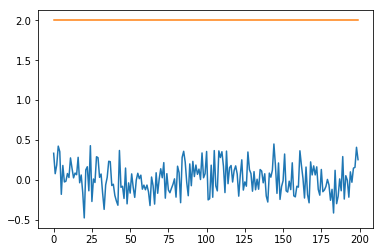

In [3]:
N_epochs = 25
n_c_i = 2#5
print("PCA")
pca = PCA(n_components=n_c_i, random_state=888, svd_solver = 'full')
X_pca = pca.fit_transform(X)
# print("X_pca_0",X_pca_0[0:10,:])
# print("")
# print("Explained variance ratio (cumsum)", np.cumsum(pca.explained_variance_ratio_))
# print("")
print("n_components = ",n_c_i)
utils.pca_err(X, X_pca)
print("Explained variance ratio (cumsum)", np.cumsum(pca.explained_variance_ratio_))
# plot
utils.myPlot(X_pca,2)


## Try AE7, AE10, AE15, AE20, AE25
- AE-15: MSE 1.3%
- AE-15-3 (non-symmetric): 0.7%
- AE-15-3 (symmetric): 1.1%

autoencoder
n_components =  15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                45        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 32        
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1977: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


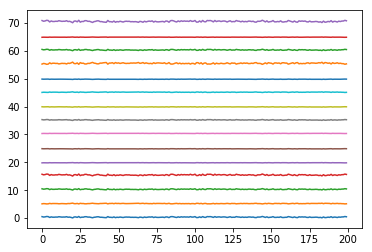

AE1 mse =  0.0133612603166


In [4]:
print("autoencoder")
N_epochs = 200
n_c_i = 15 # [7,10,15,20,25]: # 'mle'
print("n_components = ",n_c_i)

autoencoder, encoder = utils.buildNetwork(X.shape[1], encoding_dim_ae = n_c_i)
autoencoder.summary()
X_rec = utils.ae_fit_encode_plot_mse(X, autoencoder, encoder, N_epochs, verbose=0)
print("AE1 mse = ", utils.mse(X, X_rec))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                45        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 48        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 8         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1977: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train on 8000 samples, validate on 2000 samples
INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.
INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.
INFO:tensorflow:Summary name dense_4/kernel:0 is illegal; using dense_4/kernel_0 instead.
INFO:tensorflow:Summary name dense_4/bias:0 is illegal; using dense_4/bias_0 instead.
INFO:tensorflow:Summary name dense_5/kernel:0 is illegal; using dense_5/kernel_0 instead.
INFO:tensorflow:Summary name dense_5/bias:0 is illegal; using dense_5/bias_0 instead.
Epoch 1/200
0s - loss: 0.0172 - val_loss: 0.0164
Epoch 2/200
0s - loss: 0.0156 - val_loss: 0.0153
Epoch 3/200
0s - loss: 0.0145 - val_loss: 0.0140
Epoch 4/200
0s - loss: 0.0133 - val_loss: 0.0128
Epoch 5/200
0s - loss: 0.0120 - val_loss: 0.0114
Epoch 6/200
0s - loss: 0.0106 - val_loss: 0.0101
Epoch 7/200
0s - loss: 0.0094 - val_loss: 0.0090
Epoch 8/200
0s - loss: 0.0083 - val_loss: 0.0079
Epoch 9/200
0s - loss: 0.0073 - 

0s - loss: 1.9069e-05 - val_loss: 2.8282e-05
Epoch 135/200
0s - loss: 1.9567e-05 - val_loss: 1.8482e-05
Epoch 136/200
0s - loss: 1.9742e-05 - val_loss: 1.8844e-05
Epoch 137/200
0s - loss: 1.9396e-05 - val_loss: 1.5232e-05
Epoch 138/200
0s - loss: 1.8947e-05 - val_loss: 2.6521e-05
Epoch 139/200
0s - loss: 2.0018e-05 - val_loss: 2.2020e-05
Epoch 140/200
0s - loss: 1.9057e-05 - val_loss: 2.0618e-05
Epoch 141/200
0s - loss: 1.9166e-05 - val_loss: 1.8040e-05
Epoch 142/200
0s - loss: 1.9353e-05 - val_loss: 2.3536e-05
Epoch 143/200
0s - loss: 1.8971e-05 - val_loss: 1.7566e-05
Epoch 144/200
0s - loss: 1.9195e-05 - val_loss: 2.0947e-05
Epoch 145/200
0s - loss: 1.8547e-05 - val_loss: 1.5342e-05
Epoch 146/200
0s - loss: 1.9259e-05 - val_loss: 2.8460e-05
Epoch 147/200
0s - loss: 1.9575e-05 - val_loss: 2.4467e-05
Epoch 148/200
0s - loss: 1.8975e-05 - val_loss: 1.7180e-05
Epoch 149/200
0s - loss: 1.8901e-05 - val_loss: 1.8709e-05
Epoch 150/200
0s - loss: 1.9229e-05 - val_loss: 2.0648e-05
Epoch 151/2

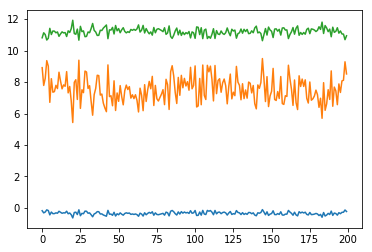

AE2 mse =  0.00784595516992


In [5]:
# https://stackoverflow.com/a/43549608/4126114
tensorboard = keras.callbacks.TensorBoard(log_dir='/tmp/tb/r0-AE-15-3-nonsymmetric',
                 histogram_freq=10, 
                 write_graph=True, 
                 write_images=False)

autoencoder, encoder = utils.buildNetwork2_deep(X.shape[1], enc_dim1 = n_c_i, enc_dim2 = 3, symmetric=False)
autoencoder.summary()
X_rec = utils.ae_fit_encode_plot_mse(X, autoencoder, encoder, N_epochs, verbose=2, callbacks=[tensorboard])
print("AE2 mse = ", utils.mse(X, X_rec))

## USE lstm-based autoencoder

In [6]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM
from keras.layers import RepeatVector, TimeDistributed, Input
from keras.layers.advanced_activations import LeakyReLU #, PReLU

in_neurons = X.shape[1]
print(in_neurons)
out_neurons = in_neurons
hidden_neurons = 25
# set below by judging by the crescents of the sin and cos in data generation
# look back = 50 with hidden neurons = 25 => MSE = 0.008
# look back = 100 with hidden neurons = 25 => MSE = 0.05
# ditty with enc_dim = 3 => MSE = ?
# BUT PERHAPS MEASURING WITH MSE LIKE THIS IS NOT GOOD
# BECAUSE I SEE THAT THE PREDICTED SIGNAL IS LAGGED
# I PROBABLY NEED SOME ALIGNMENT BEFORE CALCULATING MSE
look_back = 100 # FIXME
enc_dim = None #3 # FIXME None

autoencoder = Sequential()

# autoencoder.add(Input(shape=(look_back, in_neurons))

# combined from Simple_LSTM_keras_2 and LSTM book, chap 9, seq2seq
autoencoder.add(LSTM(hidden_neurons, return_sequences=False, input_shape=(None, in_neurons)))

# encoder layer
if enc_dim is not None:
    autoencoder.add(Dense(enc_dim, activation='linear'))
    autoencoder.add(LeakyReLU(alpha=.3))

autoencoder.add(RepeatVector(look_back))
autoencoder.add(LSTM(hidden_neurons, return_sequences=True))
autoencoder.add(TimeDistributed(Dense(out_neurons, activation='linear')))

autoencoder.compile(loss="mean_squared_error", optimizer="rmsprop")

autoencoder.summary()

2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                2800      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 100, 25)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 25)           5100      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 2)            52        
Total params: 7,952
Trainable params: 7,952
Non-trainable params: 0
_________________________________________________________________


In [7]:
# https://stackoverflow.com/a/21230438/4126114
# Testing:
#    running_view(np.array([1,2,3,4,5,6,7,8,9,10]),3,0)
#    running_view(np.array([[1,2],[3,4],[5,6],[7,8],[9,10]]),3,0)
def running_view(arr, window, axis=-1):
    """
    return a running view of length 'window' over 'axis'
    the returned array has an extra last dimension, which spans the window
    """
    shape = list(arr.shape)
    shape[axis] -= (window-1)
    assert(shape[axis]>0)
    return np.lib.index_tricks.as_strided(
        arr,
        shape + [window],
        arr.strides + (arr.strides[axis],))

def _load_data_strides(data, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """
    docX = running_view(data, n_prev, 0)
    docX = np.array([y.T for y in docX])
    return docX

def train_test_split(df, test_size=0.1):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))

    #X_train, y_train = _load_data(df.iloc[0:ntrn], y.iloc[0:ntrn])
    #X_test, y_test = _load_data(df.iloc[ntrn:], y.iloc[ntrn:])
    # alternative to the for loop in the original load data
    # Note that both the original load data and the stride consume a lot of memory
    X_train = _load_data_strides(df[:ntrn,:], look_back)
    X_test = _load_data_strides(df[ntrn:,:], look_back)

    return (X_train), (X_test)

print('done')

done


(10000, 2) (8901, 100, 2) (901, 100, 2)


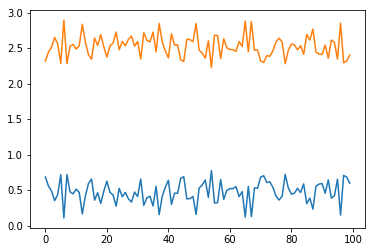

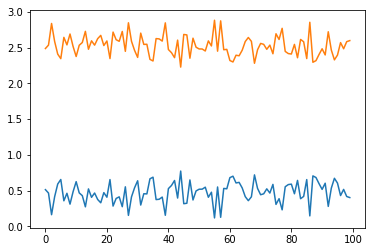

In [8]:
(X_train), (X_test) = train_test_split(X)  # retrieve data
print(X.shape, X_train.shape, X_test.shape)

#x2 = [100+x for x in range(len(y_test))]
#print(len(x2),x2)

utils.myPlot(X_test[0],2)
utils.myPlot(X_test[10],2)

In [9]:
# https://stackoverflow.com/a/43549608/4126114
tensorboard = keras.callbacks.TensorBoard(log_dir='/tmp/tb/r2-lstm-25',
                 histogram_freq=10, 
                 write_graph=True, 
                 write_images=False)


epochs=200 # FIXME # 10
autoencoder.fit(X_train, X_train, batch_size=450, epochs=epochs, validation_split=0.05, callbacks=[tensorboard])

Train on 8455 samples, validate on 446 samples
INFO:tensorflow:Summary name lstm_1/kernel:0 is illegal; using lstm_1/kernel_0 instead.
INFO:tensorflow:Summary name lstm_1/recurrent_kernel:0 is illegal; using lstm_1/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name lstm_1/bias:0 is illegal; using lstm_1/bias_0 instead.
INFO:tensorflow:Summary name lstm_2/kernel:0 is illegal; using lstm_2/kernel_0 instead.
INFO:tensorflow:Summary name lstm_2/recurrent_kernel:0 is illegal; using lstm_2/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name lstm_2/bias:0 is illegal; using lstm_2/bias_0 instead.
INFO:tensorflow:Summary name time_distributed_1/kernel:0 is illegal; using time_distributed_1/kernel_0 instead.
INFO:tensorflow:Summary name time_distributed_1/bias:0 is illegal; using time_distributed_1/bias_0 instead.
Epoch 1/200
8100/8455 [===========================>..] - ETA: 0s - loss: 0.0867

InvalidArgumentError: Shape [-1,2] has negative dimensions
	 [[Node: input_2 = Placeholder[dtype=DT_FLOAT, shape=[?,2], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'input_2', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-834b4d8d822a>", line 7, in <module>
    autoencoder, encoder = utils.buildNetwork2_deep(X.shape[1], enc_dim1 = n_c_i, enc_dim2 = 3, symmetric=False)
  File "/home/ubuntu/test-ml/t2-LSTM/utils.py", line 65, in buildNetwork2_deep
    input_img = Input(shape=(input_shape,))
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/keras/engine/topology.py", line 1426, in Input
    input_tensor=tensor)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/keras/legacy/interfaces.py", line 88, in wrapper
    return func(*args, **kwargs)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/keras/engine/topology.py", line 1337, in __init__
    name=self.name)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 431, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1530, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1954, in _placeholder
    name=name)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Shape [-1,2] has negative dimensions
	 [[Node: input_2 = Placeholder[dtype=DT_FLOAT, shape=[?,2], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
predicted = autoencoder.predict(X_test)  
rmse = utils.mse(X_test[:,0,:], predicted[:,0,:])
print(1, X_test.shape, predicted.shape, rmse)

#utils.myPlot(predicted[:,0,:],2)
#utils.myPlot(X_test[:,0,:],2)
utils.myPlot(predicted[:,0,:],2)
utils.myPlot(X_test[:,0,:],2)

In [ ]:
#--------------------
print('-'*10)
from keras.models import Model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[2].output)
encoder.compile(loss="mean_squared_error", optimizer="rmsprop")
encoder.summary()

X_enc = encoder.predict(X_test)

In [ ]:
print(X_test.shape, X_enc.shape)
utils.myPlot(X_enc[:,0,:],2) # should not need utils.myNorm3